<a href="https://colab.research.google.com/github/APFFM/project1/blob/main/1_Detailed_visualisation_of_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [42]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import tensorflow
import keras
import datetime
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import yfinance as yf
import itertools

# Input Data from Yahoo Finance

**[TICKER] Need to be inputted here

In [43]:
ticker = 'AAPL'

In [44]:
DF = yf.download(ticker, start="2019-01-01", end="2023-11-15")
DF.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-01-02   38.722500   39.712502   38.557499   39.480000   37.893330   
2019-01-03   35.994999   36.430000   35.500000   35.547501   34.118874   
2019-01-04   36.132500   37.137501   35.950001   37.064999   35.575382   
2019-01-07   37.174999   37.207500   36.474998   36.982498   35.496201   
2019-01-08   37.389999   37.955002   37.130001   37.687500   36.172878   
...                ...         ...         ...         ...         ...   
2023-11-08  182.350006  183.449997  181.589996  182.889999  182.649368   
2023-11-09  182.960007  184.119995  181.809998  182.410004  182.169998   
2023-11-10  183.970001  186.570007  183.529999  186.399994  186.399994   
2023-11-13  185.820007  186.029999  184.210007  184.800003  184.800003   
2023-11-14  187.699997  188.110001  186.300003  187.440002  187.440002   

       

In [45]:
# #Get stock quote - we import just the opening and closing Prices of stock, over 20 years duration

# df=web.DataReader(ticker, data_source='yahoo', start='2012-01-01', end='2020-05-24')    #YYYY-MM-DD
# df

In [46]:
# # Corrected end date format
# end_date = datetime.datetime(2017, 10, 1)

# # Fetch AAPL stock data
# DF = pdr.get_data_yahoo(f'100', start='2002-01-01', end=end_date)
# DF.head()

In [47]:
#choose plotting style

#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
#plt.style.use('seaborn')

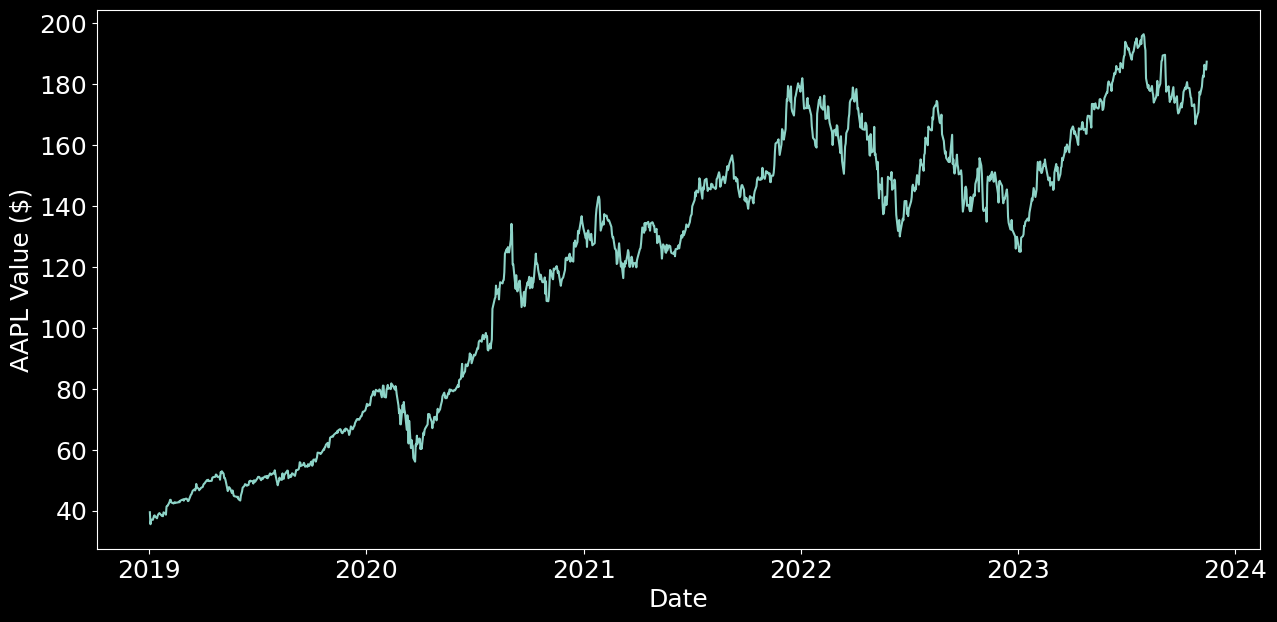

In [48]:
plt.figure(figsize=(15,7))
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel(f'{ticker} Value ($)')
plt.rcParams.update({'font.size': 18})

# Define Functions

In [49]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))


def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)


def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

# Creating Features

In [50]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

<ipython-input-50-e45bebd0ac9c>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)


# Initial Visualization

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,44.557499,-0.004135,111792800,-0.003856,0.015064,-0.109655,-0.211892,-0.027699,-0.080801,-0.088769,-0.014197,0.022136,-0.008669
1,44.345001,-0.004769,113924800,0.005442,0.019034,-0.068800,-0.175885,-0.025332,-0.079657,-0.092127,-0.020804,0.013924,-0.013550
2,44.575001,0.005187,84873600,0.001967,0.014490,-0.293964,-0.344692,-0.015842,-0.067086,-0.086649,-0.017355,0.005290,-0.020970
3,43.767502,-0.018116,108174400,-0.006582,0.017144,-0.081838,-0.158350,-0.026386,-0.075745,-0.101990,-0.036597,-0.004471,-0.028396
4,43.325001,-0.010110,161584400,-0.013098,0.044929,0.337364,0.220174,-0.028407,-0.075709,-0.109078,-0.047520,-0.014334,-0.036103


<Figure size 640x480 with 0 Axes>

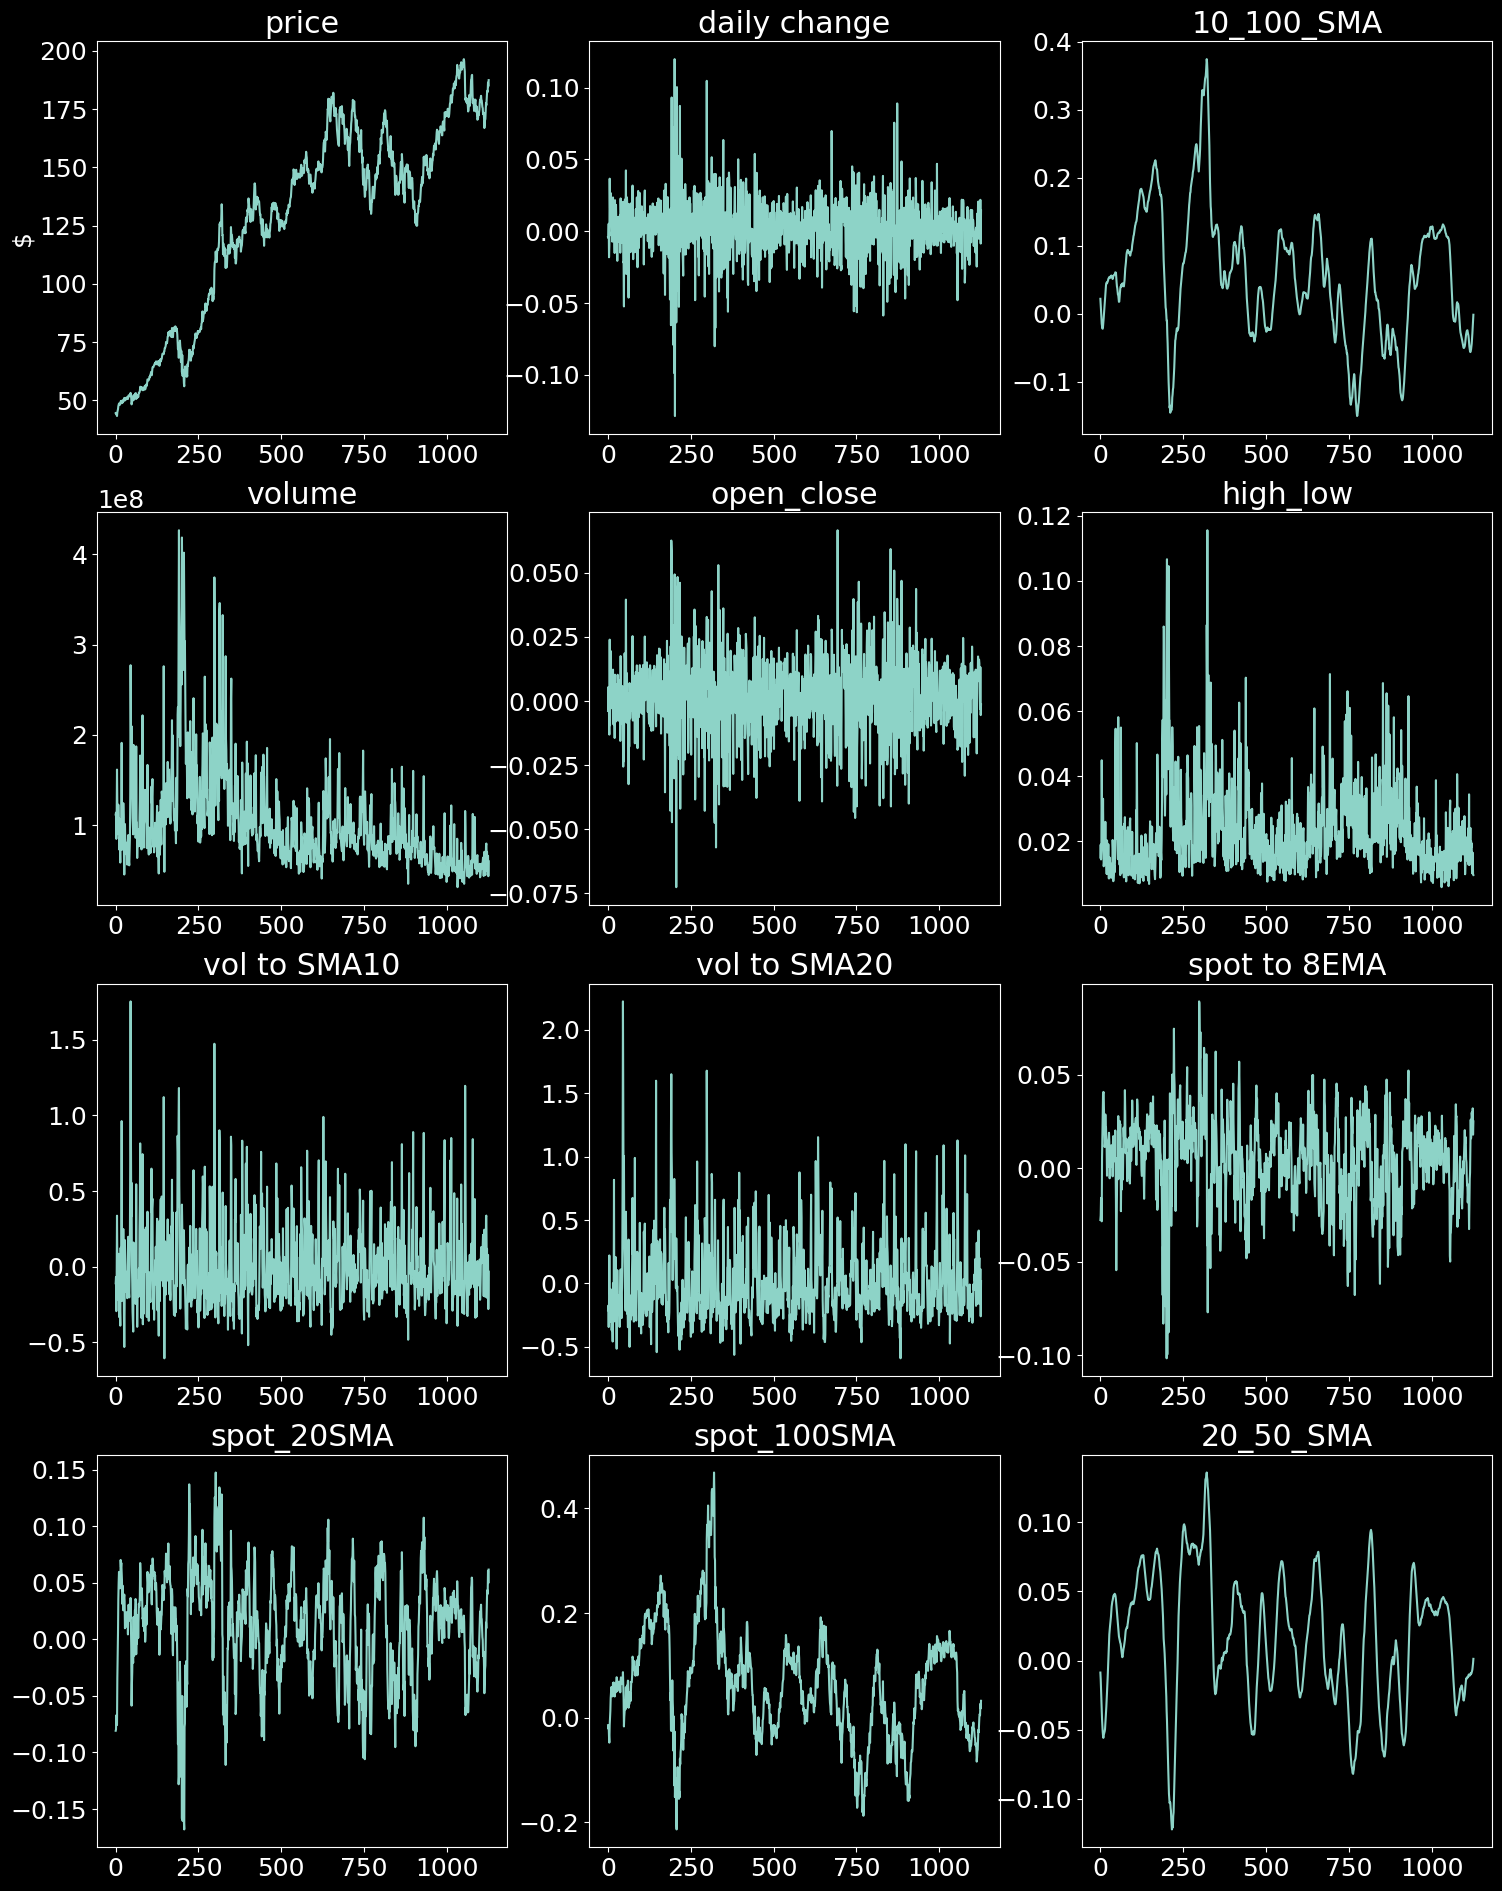

In [51]:
fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')